Brian Blaylock  
January 22, 2018

# Mapping Occurrence of High Winds
i.e. How often the 95th percentile wind at [given hours] for every day of the [given months] is greater than 10 m/s.

Remember, the 95th percentile was calculated for the +/-15 days of the hour for all years.

** Doing statistics with statistics is confusing. ** Are there overlapping samples??

In [11]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import OrderedDict

import sys
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_data.grid_manager import pluck_point_new

from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b\n%d')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300

In [12]:
m = draw_CONUS_HRRR_map()

### Get lat/lon grid from file for plotting

In [46]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

## Get OSG field

In [14]:
def get_field_MP(inputs):
    """
    Function for MultiProcessing:
    Return the value from a point in the HDF5 file array
    """
    FILE, STAT = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            return f[STAT].value
    except:
        #print "COULD NOT GET", FILE
        return np.nan

------

# Summarize the statistics
i.e. How often are the 95th percentile winds greater than 10 m/s?

In [29]:

var = 'UVGRD:10 m'
stat = 'p95'
threshold = 10

#hours = range(24)
hours = [18]

months = [9,10,11]


##### Additional setup

In [30]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)


days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Dates (with leap year)
DAYS = days[months[0]-1:months[-1]]
HOURS = np.sum(DAYS)*24 # number of days times 24
DATES = np.array([datetime(2016, months[0], 1) + timedelta(hours = h) for h in range(HOURS)])
DATES = DATES[::24/len(hours)] # in case we don't request all 24 hours


In [31]:
args = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
            (variable, month, day, hour), stat ]\
            for month in months for day in range(1,days[month-1]+1) for hour in hours]

In [32]:
args[0]

['/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/UVGRD_10_m/OSG_HRRR_UVGRD_10_m_m09_d01_h18_f00.h5',
 'p95']

In [33]:
cpu = multiprocessing.cpu_count()
chunks = range(0, len(args), cpu)
chunks.append(len(args))
print chunks

[0, 24, 48, 72, 91]


In [34]:
fill_array = np.zeros_like(lat) # an array of zeros the same size as the HRRR domain
count = len(args)
for i, chunk in enumerate(chunks[:-1]):
    # 1) Get the data arrays from each chuck
    MP_args = args[chunks[i]: chunks[i+1]]
    p = multiprocessing.Pool(cpu)
    these_fields = np.array(p.map(get_field_MP, MP_args))
    p.close()
    # 2) Count how often those values exceed the threshold and add to total count in fill_array
    gte_thresh = these_fields >= threshold
    fill_array += np.sum(gte_thresh, axis=0)
    
    print chunk,

0 24 48 72


In [35]:
count

91

In [36]:
occurrence = (fill_array/count)*100

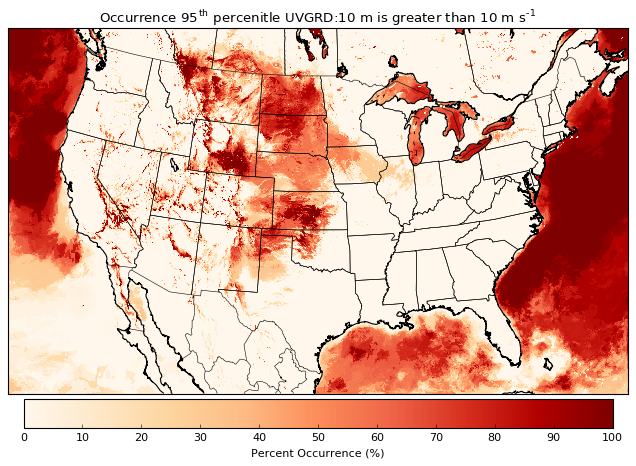

In [37]:
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.pcolormesh(lon, lat, occurrence,
             cmap= 'OrRd',
             latlon=True)

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Percent Occurrence (%)')

plt.title(r'Occurrence %s$\mathregular{^{th}}$ percenitle %s is greater than %s m s$\mathregular{^{-1}}$' % (stat[1:], var, threshold))

#plt.savefig('./figs/occurrence_UVGRD10m_p95_ALLHOURS_SON')


In [262]:
# np.save('occurrence_UVGRD_10m_p95_ALLHOURS_SON', occurrence)

In [283]:
period = 'SON'
a = np.load('occurrence_UVGRD_10m_p95_ALLHOURS_%s.npy' % period)

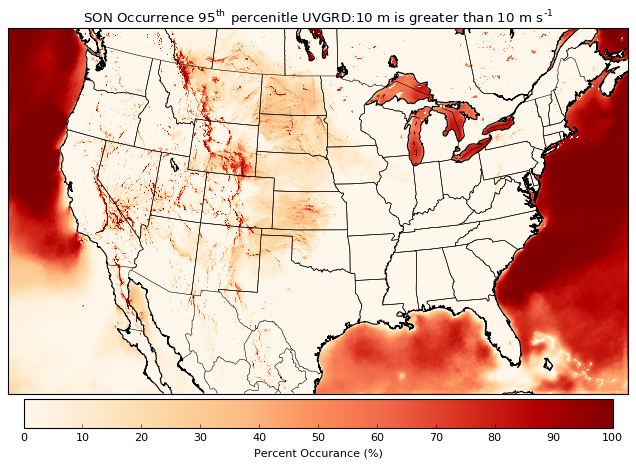

In [284]:
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.pcolormesh(lon, lat, a,
             cmap= 'OrRd',
             latlon=True)

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Percent Occurrence (%)')

plt.title(r'%s Occurrence %s$\mathregular{^{th}}$ percenitle %s is greater than %s m s$\mathregular{^{-1}}$' % (period, stat[1:], var, threshold))

plt.savefig('./figs/occurrence_UVGRD10m_p95_ALLHOURS_%s' % period)

# For a Smaller Domain

In [94]:
from mpl_toolkits.basemap import Basemap

# Map Center
cLAT = 38.6
cLON = -122.714

plus_minus_latlon = 5

# Make Map Object
m = Basemap(resolution='i', projection='cyl',\
            area_thresh=3000,\
            llcrnrlon=cLON-plus_minus_latlon, llcrnrlat=cLAT-plus_minus_latlon,\
            urcrnrlon=cLON+plus_minus_latlon, urcrnrlat=cLAT+plus_minus_latlon,)

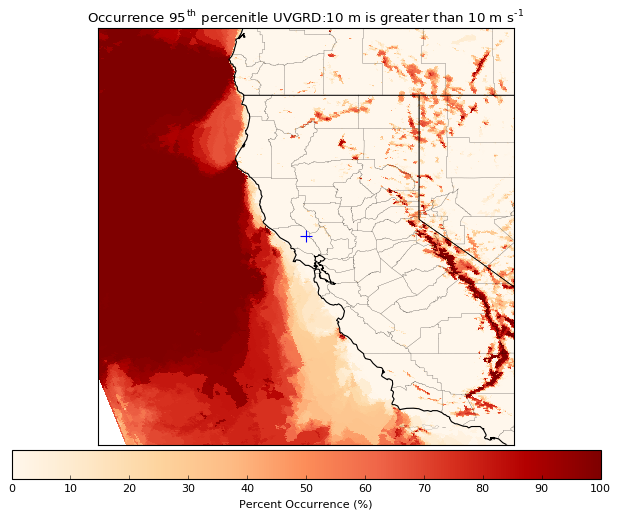

In [95]:
m.drawstates()
m.drawcounties()
m.drawcoastlines()
m.pcolormesh(lon, lat, occurrence,
             cmap='OrRd',
             latlon=True)

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Percent Occurrence (%)')

plt.title(r'Occurrence %s$\mathregular{^{th}}$ percenitle %s is greater than %s m s$\mathregular{^{-1}}$' % (stat[1:], var, threshold))

m.scatter(cLON, cLAT, marker='+', c='b', s=100, zorder=1000, latlon=True)

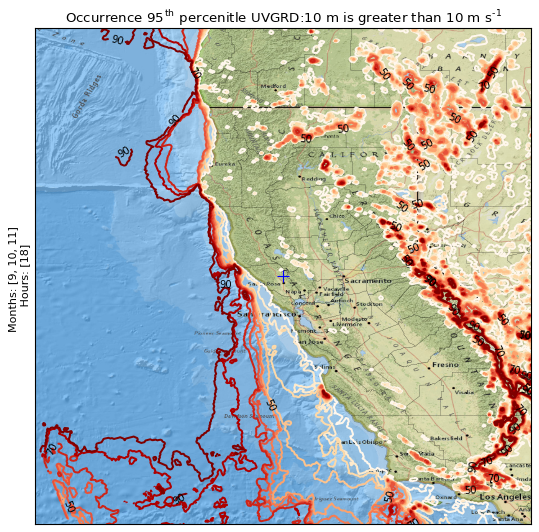

In [96]:
m.drawstates()
m.drawcounties()
#m.arcgisimage(service='World_Shaded_Relief', xpixels=800, verbose=False)
m.arcgisimage(service='NatGeo_World_Map', xpixels=800, verbose=False)

con = m.contour(lon, lat, occurrence,
          levels=range(0,100,10),
          cmap='OrRd',
          latlon=True)
plt.clabel(con, con.levels[5::2], fmt='%2.0f', colors='k', fontsize=9)

plt.title(r'Occurrence %s$\mathregular{^{th}}$ percenitle %s is greater than %s m s$\mathregular{^{-1}}$' % (stat[1:], var, threshold))
plt.ylabel('Months: %s \n Hours: %s' % (months, hours))

m.scatter(cLON, cLAT, marker='+', c='b', s=100, zorder=1000, latlon=True)

I'm worried that counting the occurrence of percentile statistics is causing double sampling, because each percentile statistic is calculated for +/-15 days, so samples are being counted many times in the stats.
I think what I need to do is formulate a new metric that counts the true occurrence of winds greater than 10 m/s for all the data in the HRRR archive.